In [1]:
# get matplotlib configuration
%run plot_conf.py

In [2]:
import os
import numpy as np

In [3]:
# load network 001 and 002 train losses
nets = ('001', '002')
net_train_loss = dict()
for net in nets:
    with os.popen("awk '/data/{print $18,$21}' ../results/" + net + "/train.log") as pipe:
        net_train_loss[net] = np.loadtxt(pipe)
net_train_loss['001'] *= 100
net_train_loss['002'] *= 100

In [5]:
# load network > 002 train losses
nets = ('006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '018', '019')
for net in nets:
    with os.popen("awk '/data/{print $18,$21,$25}' ../results/" + net + "/train.log") as pipe:
        net_train_loss[net] = np.loadtxt(pipe)

In [13]:
b = net_train_loss['007'].shape[0] // 10
loss_names = ['MSE', 'CE', 'rpl MSE', 'per CE']

In [7]:
def plot_loss(loss, legend, lim, l_names):
    z = tuple(loss_names.index(n) for n in l_names)
    for l in loss:
        plt.plot(l[:,z])
    plt.legend([l1 + ' ' + l2 for l1 in legend for l2 in l_names])
    if lim[0]:
        if isinstance(lim[0], tuple): plt.xlim(lim[0])
        else: plt.xlim(xmax=lim[0])
    if lim[1]:
        if isinstance(lim[1], tuple): plt.ylim(lim[1])
        else: plt.ylim(ymax=lim[1])
            
def plot_batch_loss(loss, legend, lim, l_names):
    plot_loss(loss, legend, lim, l_names)
    
    # Add vertical dotted lines at the end of each epoch
    ylim = plt.ylim()
    upper_range = loss[0].shape[0] // b
    plt.vlines(
        [b*i for i in range(1, upper_range)],
        ymin=ylim[0], ymax=ylim[1], colors='y', linestyles=':', linewidth=0.75
    )
    plt.ylim(ylim)

In [8]:
def plot_batch_mse(losses, legend, lim=(None, None)):
    plot_batch_loss(losses, legend, lim, ('MSE', 'rpl MSE'))
    plt.xlabel('batch idx / 10')
    plt.title('MSE loss')
    plt.ylabel('mMSE')
    
def plot_epoch_mse(losses, legend, lim=(None, None)):
    plot_loss(losses, legend, lim, ('MSE', 'rpl MSE'))
    plt.xlabel('epoch idx')
    plt.title('MSE loss')
    plt.ylabel('mMSE')
    
    # Do start from Epoch #1
    xlim = plt.xlim()
    loc, _ = plt.xticks()
    plt.xticks(loc, [str(int(x) + 1) for x in loc])
    plt.xlim(xlim)

In [9]:
def plot_batch_ce(losses, legend, lim=(None, None)):
    plot_batch_loss(losses, legend, lim, ('CE','per CE'))
    plt.xlabel('batch idx / 10')
    plt.title('CE loss')
    plt.ylabel('nit')
    
def plot_epoch_ce(losses, legend, lim=(None, None)):
    plot_loss(losses, legend, lim, ('CE', 'per CE'))
    plt.xlabel('epoch idx')
    plt.title('CE loss')
    plt.ylabel('nit')
    
    # Do start from Epoch #1
    xlim = plt.xlim()
    loc, _ = plt.xticks()
    plt.xticks(loc, [str(int(x) + 1) for x in loc])
    plt.xlim(xlim)

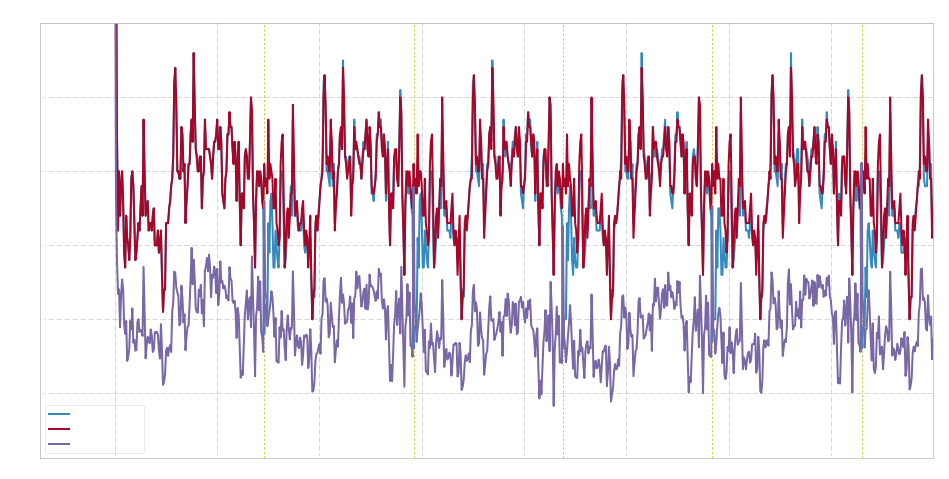

In [8]:
plot_batch_loss((net_train_loss['001'], net_train_loss['002'], net_train_loss['006']),
                ('net 001', 'net 002', 'net 006'), (800, 70), ('MSE',))
plt.title('Train MSE loss')
plt.ylabel('mMSE')

(0, 584)

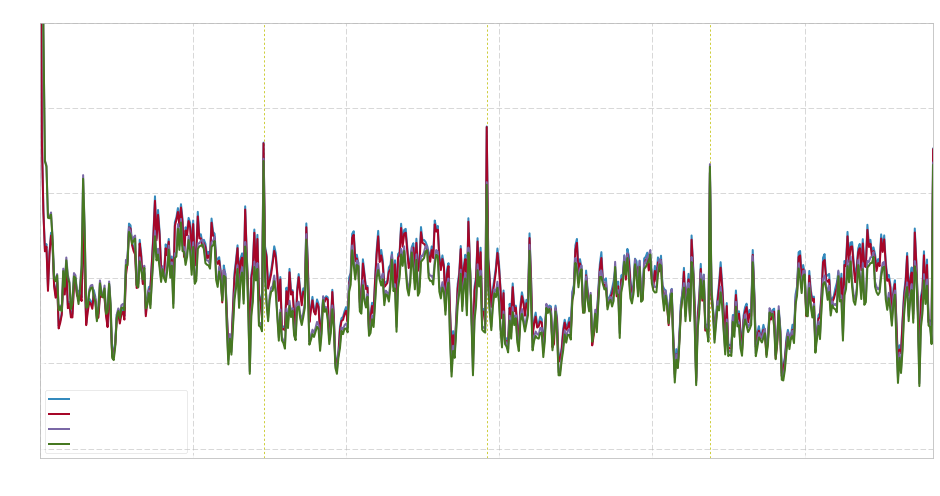

In [9]:
plot_batch_mse(
    (net_train_loss['006'], net_train_loss['007']),
    ('net 006 train', 'net 007 train'),
    (None, 60)
)
# plt.xlim((1300, 1480))
plt.xlim((0, b*4))

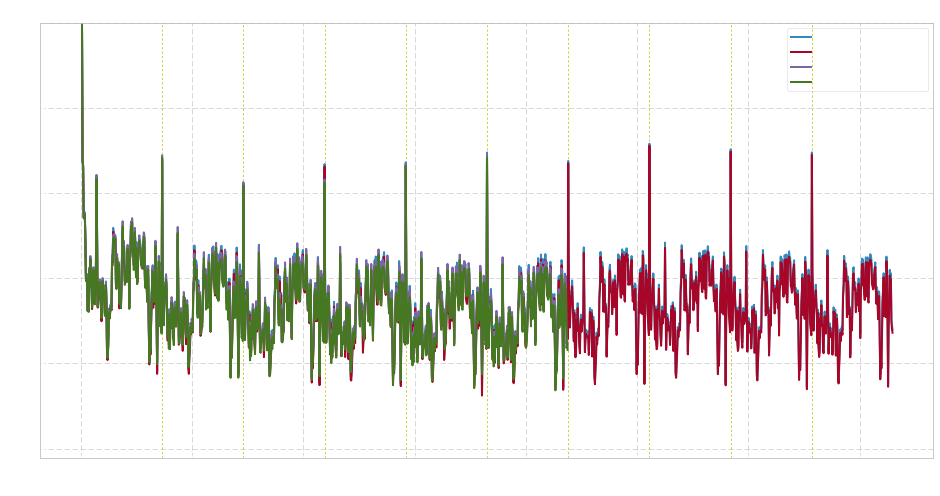

In [10]:
# Proper state selective resetting

plot_batch_mse(
    (net_train_loss['007'], net_train_loss['008']),
    ('net 007 train', 'net 008 train'),
    (None, 60)
)

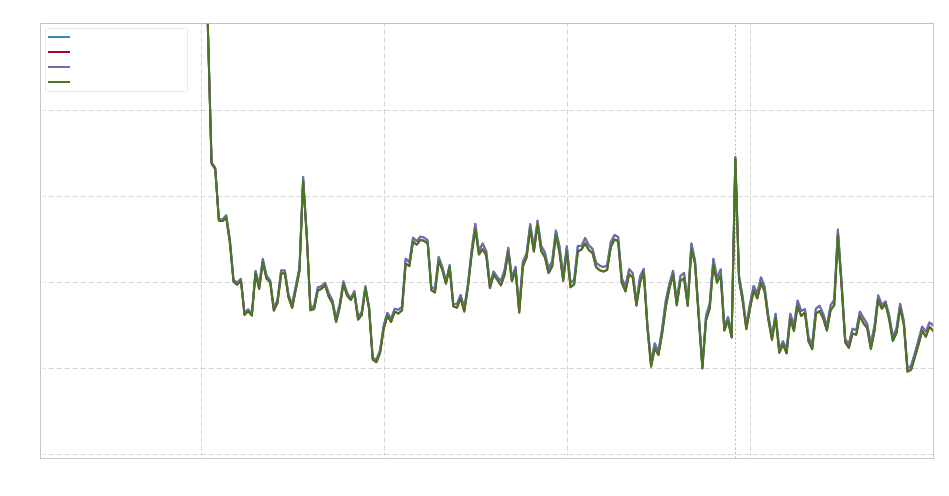

In [11]:
# lr /= 10 after 3 epochs

plot_batch_mse(
    (net_train_loss['008'], net_train_loss['009']),
    ('net 008 train', 'net 009 train'),
    (200, 60)
)

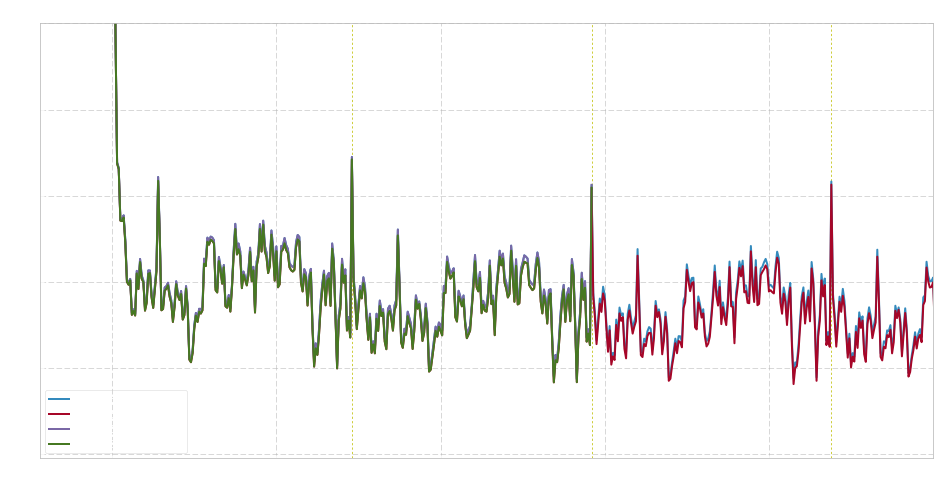

In [12]:
# brancing before summing, after G_n

plot_batch_mse(
    (net_train_loss['008'], net_train_loss['010']),
    ('net 008 train', 'net 010 train'),
    (500, 60)
)

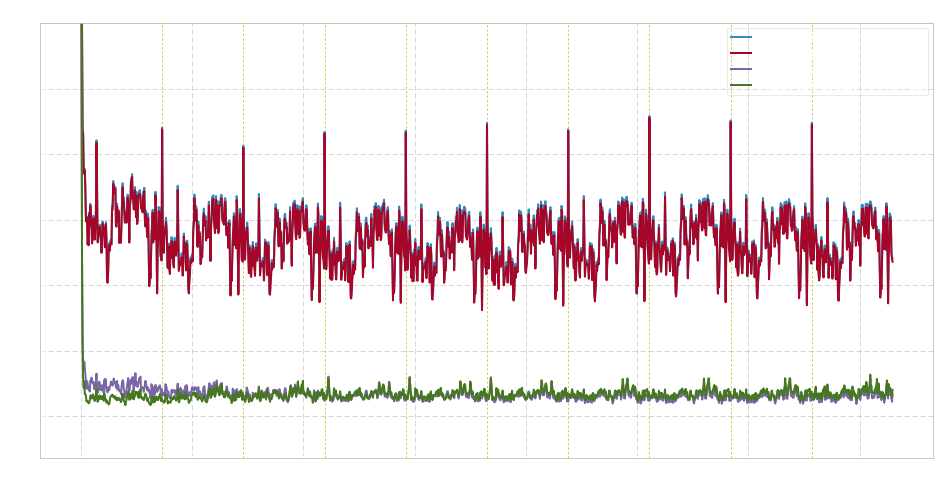

In [13]:
# model_02 vs. model_01

plot_batch_mse(
    (net_train_loss['007'], net_train_loss['011']),
    ('model_01 (net 007) train', 'model_02 (net 011) train'),
    (None, 60)
)

In [30]:
np.mean(net_train_loss['011'][1200:,0])

3.1533846153846152

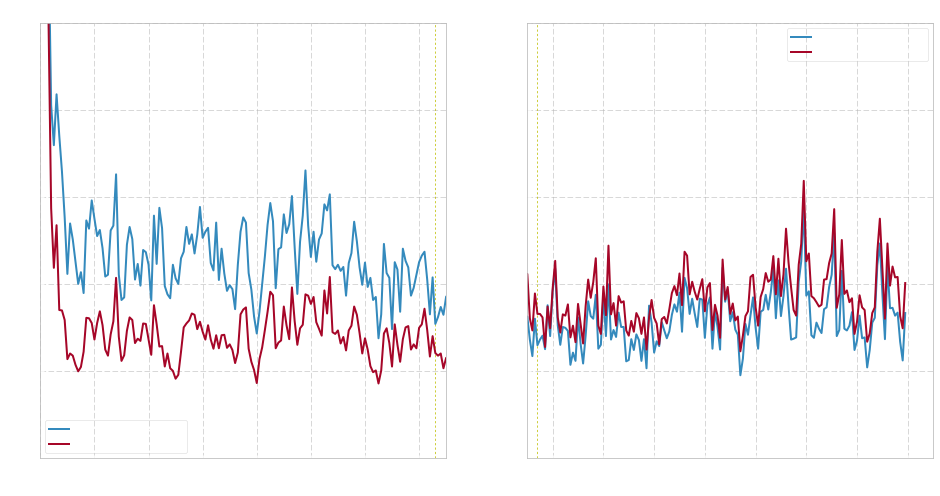

In [14]:
# model_02

plt.subplot(121)
plot_batch_mse(
    (net_train_loss['011'],),
    ('net 011 train',),
    ((0, 150), (0, 10))
)

plt.subplot(122)
plot_batch_mse(
    (net_train_loss['011'],),
    ('net 011 train',),
    ((1310, 1470), (0, 10))
)

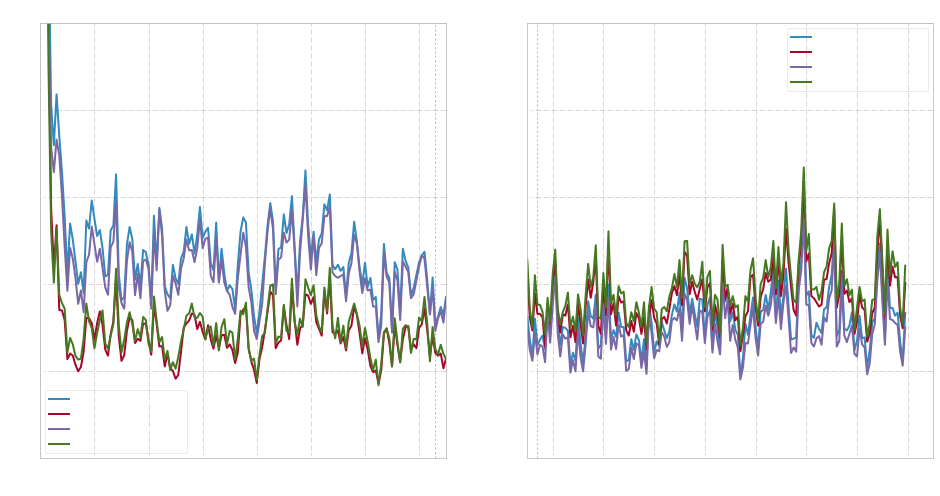

In [15]:
# proper double selective state and loss resetting

plt.subplot(121)
plot_batch_mse(
    (net_train_loss['011'], net_train_loss['012']),
    ('net 011 train', 'net 012 train'),
    ((0, 150), (0, 10))
)

plt.subplot(122)
plot_batch_mse(
    (net_train_loss['011'], net_train_loss['012']),
    ('net 011 train', 'net 012 train'),
    ((1310, 1470), (0, 10))
)

Now that we are actually getting *proper* results, it makes sense to start checking the performance on the validation set.

In [15]:
# load network > 011 validation losses
nets = ('011', '012', '014', '015', '016', '018', '019')
net_val_loss = dict()
net_mean_train_loss = dict()
for net in nets:
#     print(net)
    net_mean_train_loss[net] = np.mean(net_train_loss[net].reshape(-1, b, 3), axis=1)
    with os.popen("awk '/end/{print $11,$14,$18}' ../results/" + net + "/train.log") as pipe:
        net_val_loss[net] = np.loadtxt(pipe)
net_val_loss['012'][net_val_loss['012'] > 1e3] = np.nan
net_val_loss['012'][:,1] = 6.88
net_val_loss['014'][net_val_loss['014'] > 1e3] = np.nan
net_val_loss['015'][:,1] *= 1e3

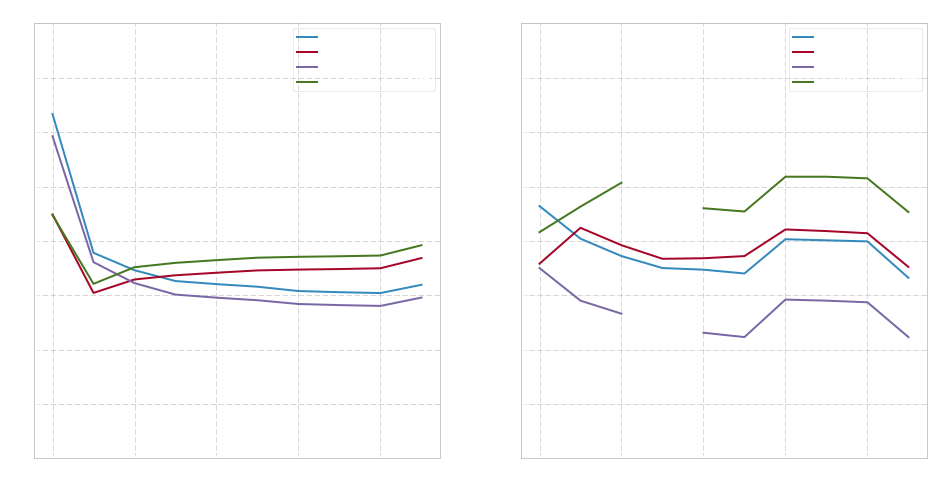

In [19]:
# proper double selective state and loss resetting

plt.subplot(121)
plot_epoch_mse(
    (net_mean_train_loss['011'], net_mean_train_loss['012']),
    ('net 011 train', 'net 012 train'),
    (None, (0, 8))
)

plt.subplot(122)
plot_epoch_mse(
    (net_val_loss['011'], net_val_loss['012']),
    ('net 011 val', 'net 012 val'),
    (None, (0, 8))
)

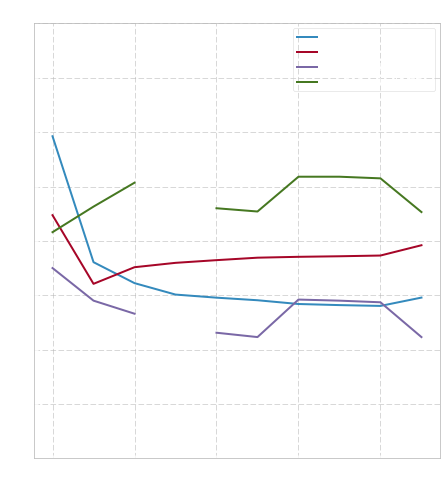

In [31]:
# proper double selective state and loss resetting

plt.subplot(1,2,1)
plot_epoch_mse(
    (net_mean_train_loss['012'], net_val_loss['012']),
    ('net 012 train', 'net 012 val'),
    (None, (0, 8))
)

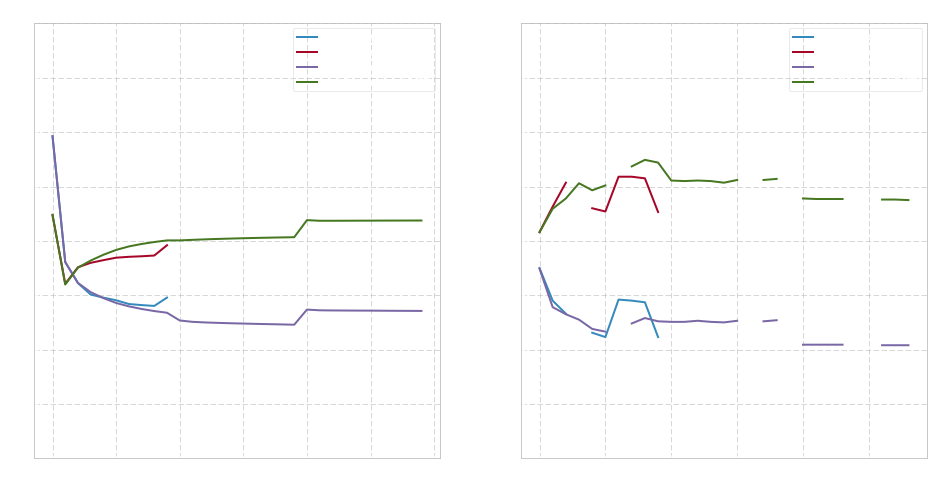

In [147]:
# lr = 0.1, √10x reduction every 3 epochs
# vs.
# lr = 0.1, 10x reduction every 10 epochs

plt.subplot(121)
plot_epoch_mse(
    (net_mean_train_loss['012'], net_mean_train_loss['014']),
    ('net 012 train', 'net 014 train'),
    (None, (0, 8))
)

plt.subplot(122)
plot_epoch_mse(
    (net_val_loss['012'], net_val_loss['014']),
    ('net 012 val', 'net 014 val'),
    (None, (0, 8))
)

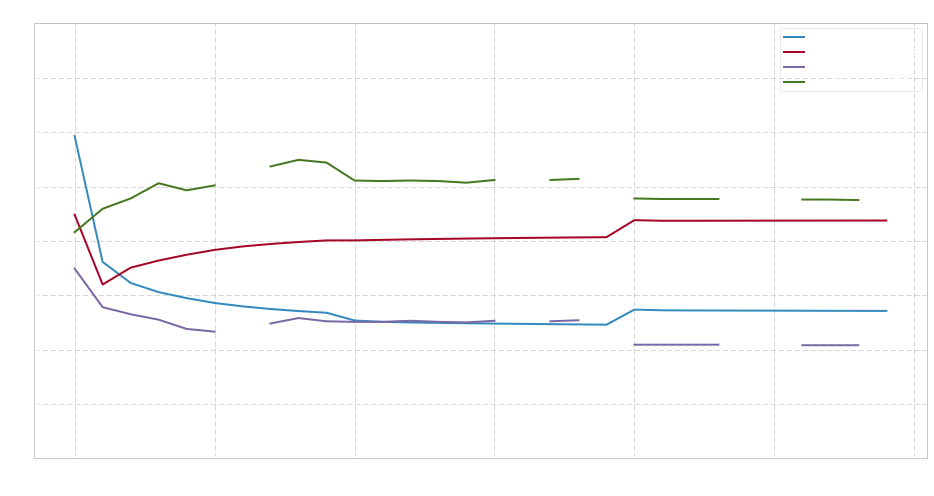

In [148]:
# different hyperparameters

plot_epoch_mse(
    (net_mean_train_loss['014'], net_val_loss['014']),
    ('net 014 train', 'net 014 val'),
    (None, (0, 8))
)

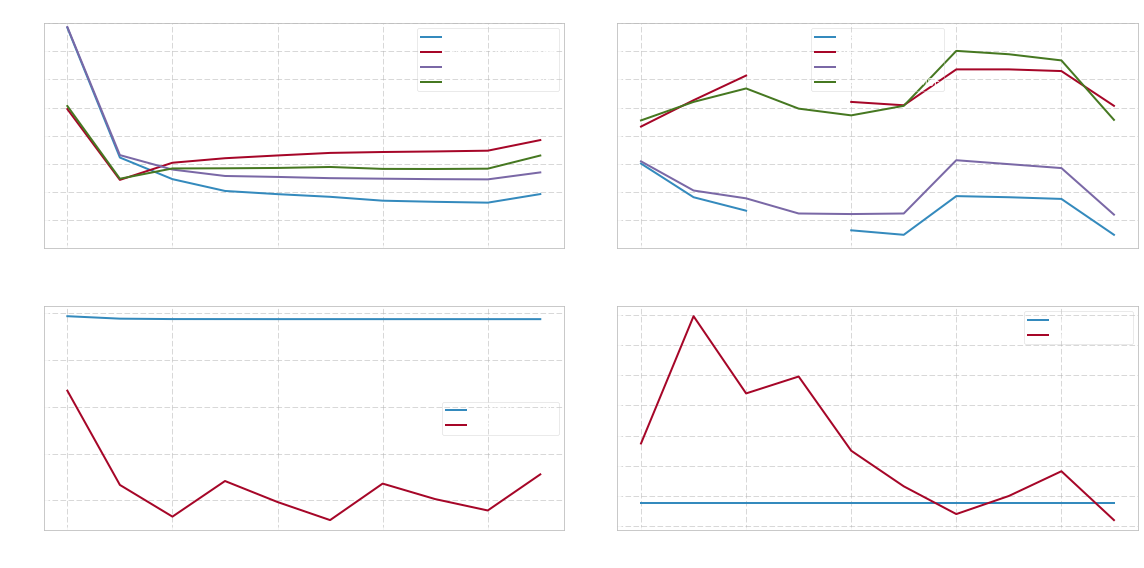

In [165]:
plt.subplot(221)
plot_epoch_mse(
    (net_mean_train_loss['012'], net_mean_train_loss['015']),
    ('net 012 train', 'net 015 train'),
    (None, (2, 6))
)

plt.subplot(222)
plot_epoch_mse(
    (net_val_loss['012'], net_val_loss['015']),
    ('net 012 val', 'net 015 val'),
    (None, (2, 6))
)

plt.subplot(223)
plot_epoch_ce(
    (net_mean_train_loss['012'], net_mean_train_loss['015']),
    ('net 012 train', 'net 015 train'),
)

plt.subplot(224)
plot_epoch_ce(
    (net_val_loss['012'], net_val_loss['015']),
    ('net 012 val', 'net 015 val'),
)

plt.tight_layout()

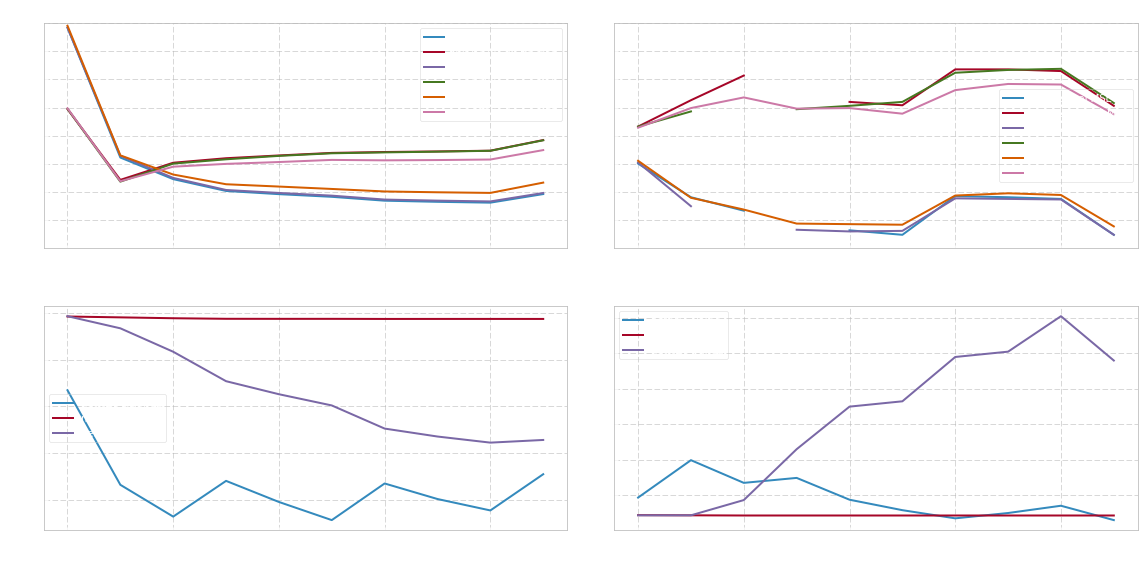

In [170]:
plt.subplot(221)
plot_epoch_mse(
    (net_mean_train_loss['012'], net_mean_train_loss['018'], net_mean_train_loss['019']),
    ('net 012 train', 'net 018 train', 'net 019 train'),
    (None, (2, 6))
)

plt.subplot(222)
plot_epoch_mse(
    (net_val_loss['012'], net_val_loss['018'], net_val_loss['019']),
    ('net 012 val', 'net 018 val', 'net 019 val'),
    (None, (2, 6))
)

plt.subplot(223)
plot_epoch_ce(
    (net_mean_train_loss['015'], net_mean_train_loss['018'], net_mean_train_loss['019']),
    ('net 015 train', 'net 018 train', 'net 019 train'),
)

plt.subplot(224)
plot_epoch_ce(
    (net_val_loss['015'], net_val_loss['018'], net_val_loss['019']),
    ('net 015 val', 'net 018 val', 'net 019 val'),
)

plt.tight_layout()

In [16]:
# load network > 002 train losses
nets = ('020', '021', '022', '023', '024', '025')
for net in nets:
#     print(net)
    with os.popen("awk '/batches/{print $18,$21,$25,$29}' ../results/" + net + "/train.log") as pipe:
        net_train_loss[net] = np.loadtxt(pipe)
    net_mean_train_loss[net] = np.mean(net_train_loss[net].reshape(-1, b, 4), axis=1)
    with os.popen("awk '/end/{print $11,$14,$18,$22}' ../results/" + net + "/train.log") as pipe:
        net_val_loss[net] = np.loadtxt(pipe)

020
021
022
023
024
025


In [17]:
net_train_loss['025'].shape

(1460, 4)

In [20]:
net_train_loss['027'].shape

(1400, 4)

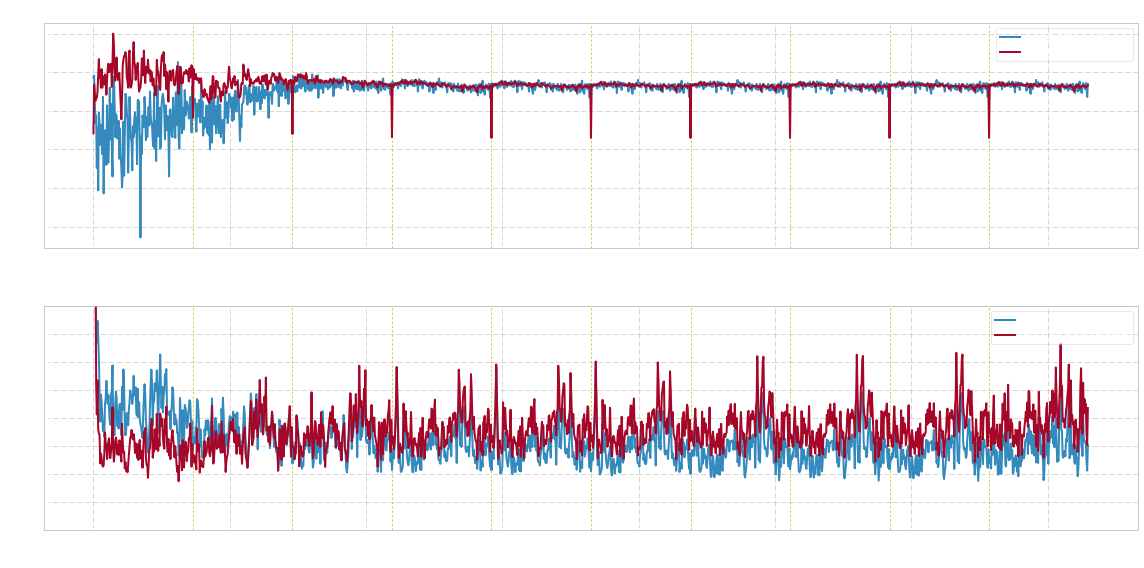

In [184]:
# altogether, μ = 1, λ = 1e−3, π = 1e−3 (no CE temporal gradient)

plt.subplot(2,1,1)
plot_batch_ce(
    (net_train_loss['020'],),
    ('net 020 train',),
)
plt.subplot(2,1,2)
plot_batch_mse(
    (net_train_loss['020'],),
    ('net 020 train',),
    (None, (0, 8))
)
plt.tight_layout()

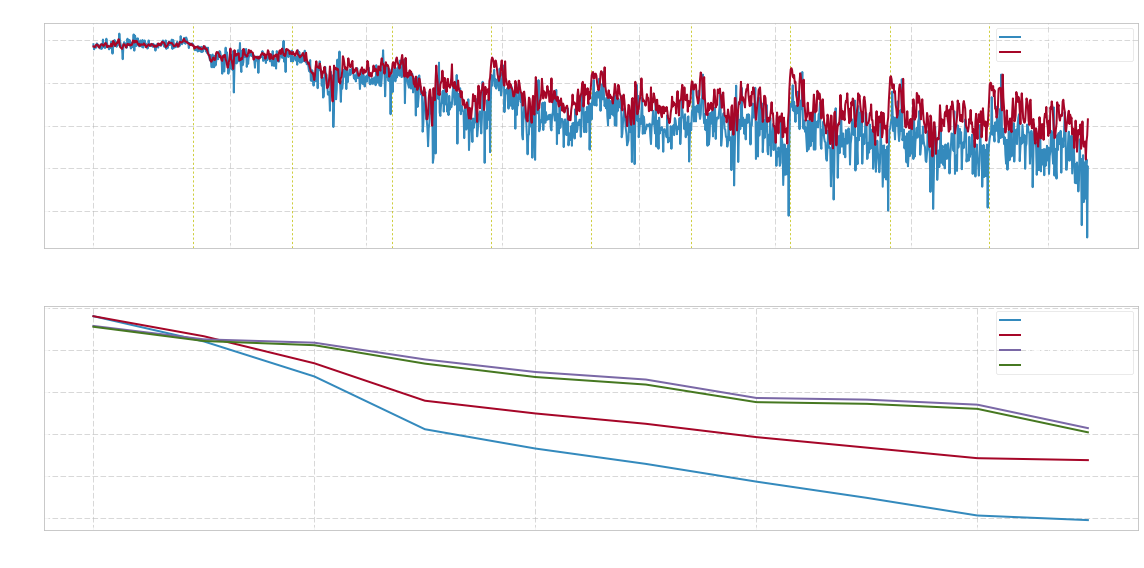

In [193]:
# altogether, μ = 0, λ = 0.01, π = 0 (CE temporal gradient)

plt.subplot(2,1,1)
plot_batch_ce(
    (net_train_loss['022'],),
    ('net 022 train',),
)
plt.subplot(2,1,2)
plot_epoch_ce(
    (net_mean_train_loss['022'], net_val_loss['022']),
    ('net 022 train', 'net 022 val'),
)
plt.tight_layout()

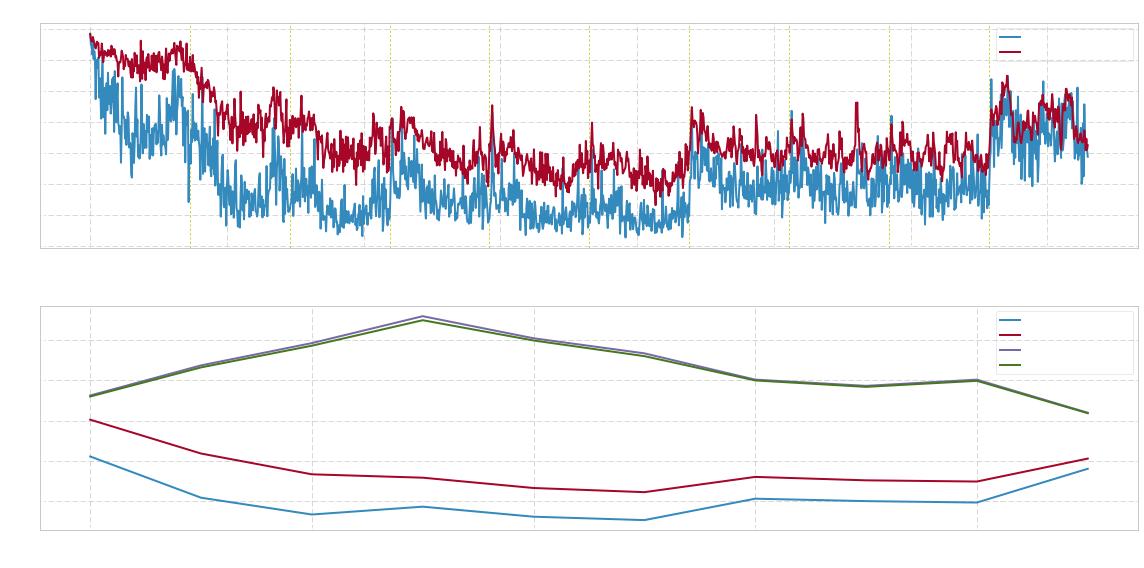

In [194]:
# altogether, μ = 0, λ = 0, π = 0.01 (CE temporal gradient)

plt.subplot(2,1,1)
plot_batch_ce(
    (net_train_loss['023'],),
    ('net 023 train',),
)
plt.subplot(2,1,2)
plot_epoch_ce(
    (net_mean_train_loss['023'], net_val_loss['023']),
    ('net 023 train', 'net 023 val'),
)
plt.tight_layout()

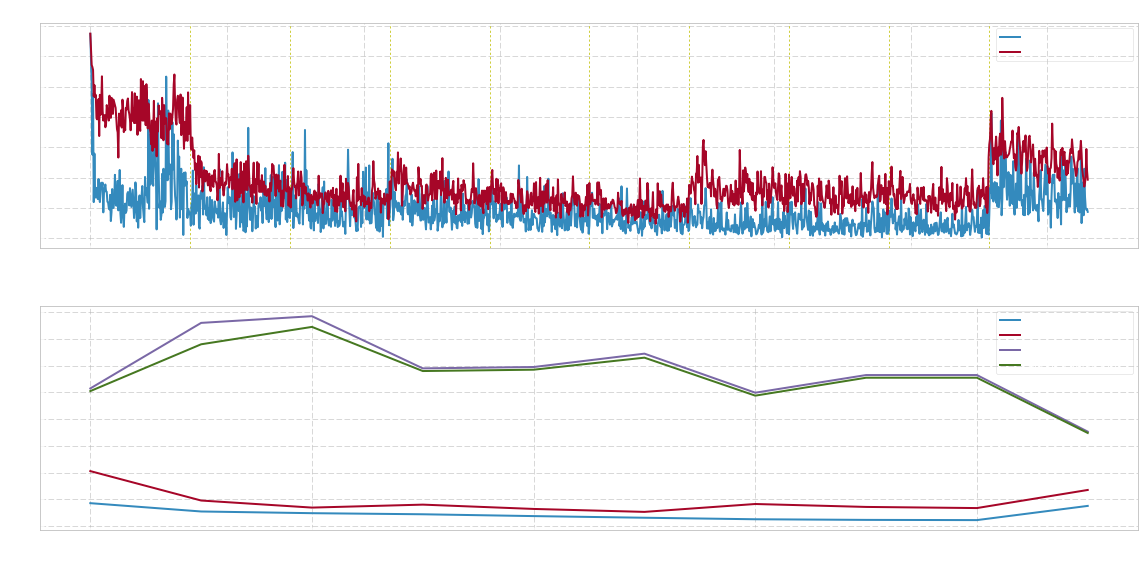

In [198]:
# altogether, μ = 0, λ = 0, π = 0.0316 (CE temporal gradient)

plt.subplot(2,1,1)
plot_batch_ce(
    (net_train_loss['025'],),
    ('net 025 train',),
)
plt.subplot(2,1,2)
plot_epoch_ce(
    (net_mean_train_loss['025'], net_val_loss['025']),
    ('net 025 train', 'net 025 val'),
)
plt.tight_layout()

In [18]:
# load network > 002 train losses
b = 140
nets = ('027', '028', '033')
for net in nets:
#     print(net)
    with os.popen("awk '/batches/{print $18,$21,$25,$29}' ../results/" + net + "/train.log") as pipe:
        net_train_loss[net] = np.loadtxt(pipe)
    net_mean_train_loss[net] = np.mean(net_train_loss[net].reshape(-1, b, 4), axis=1)
    with os.popen("awk '/end/{print $11,$14,$18,$22}' ../results/" + net + "/train.log") as pipe:
        net_val_loss[net] = np.loadtxt(pipe)

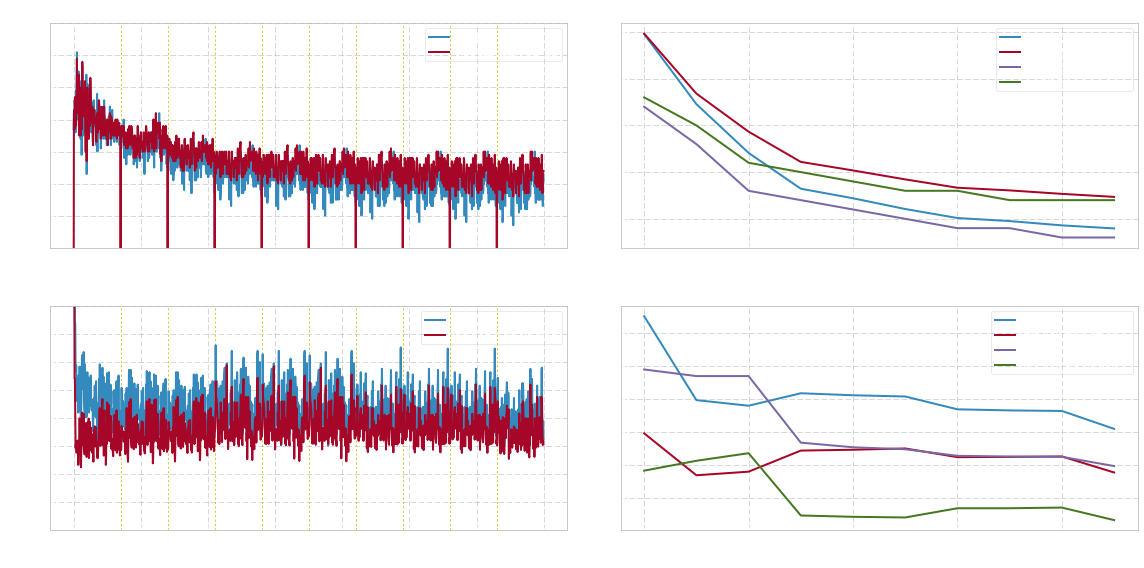

In [32]:
plt.subplot(2,2,1)
plot_batch_ce(
    (net_train_loss['028'],),
    ('net 028 train',),
    (None, (6.5, 7.2))
)
plt.subplot(2,2,3)
plot_batch_mse(
    (net_train_loss['028'],),
    ('net 028 train',),
    (None, (0, 20))
)
plt.subplot(2,2,2)
plot_epoch_ce(
    (net_mean_train_loss['028'], net_val_loss['028']),
    ('net 028 train', 'net 028 val'),
)
plt.subplot(2,2,4)
plot_epoch_mse(
    (net_mean_train_loss['028'], net_val_loss['028']),
    ('net 028 train', 'net 028 val'),
)
plt.tight_layout()

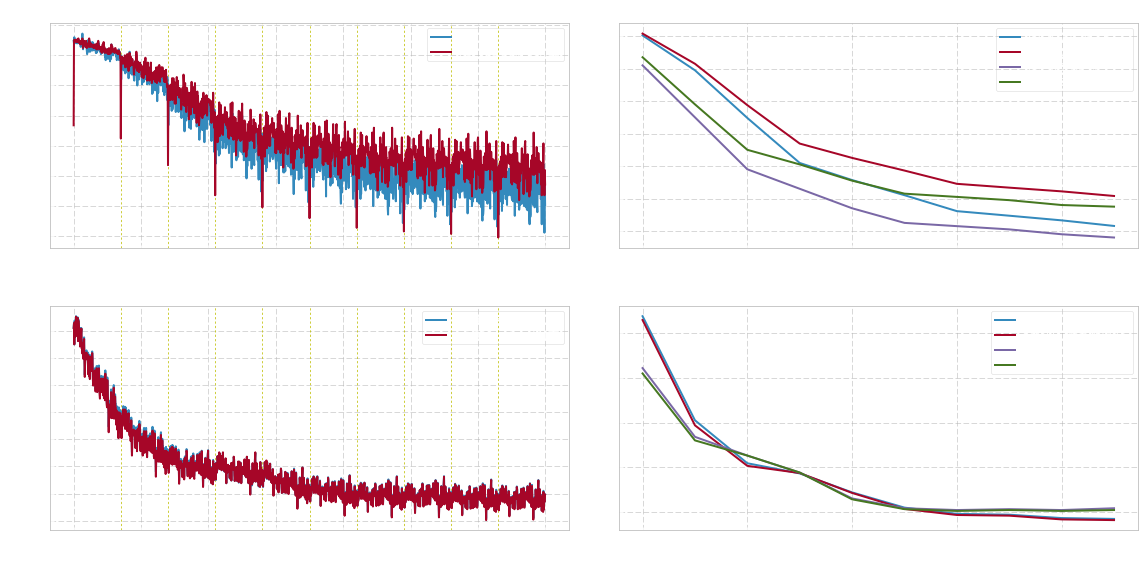

In [35]:
plt.subplot(2,2,1)
plot_batch_ce(
    (net_train_loss['027'],),
    ('net 028 train',),
#     (None, (6.5, 7.2))
)
plt.subplot(2,2,3)
plot_batch_mse(
    (net_train_loss['027'],),
    ('net 028 train',),
#     (None, (0, 20))
)
plt.subplot(2,2,2)
plot_epoch_ce(
    (net_mean_train_loss['027'], net_val_loss['027']),
    ('net 027 train', 'net 027 val'),
)
plt.subplot(2,2,4)
plot_epoch_mse(
    (net_mean_train_loss['027'], net_val_loss['027']),
    ('net 027 train', 'net 027 val'),
)
plt.tight_layout()

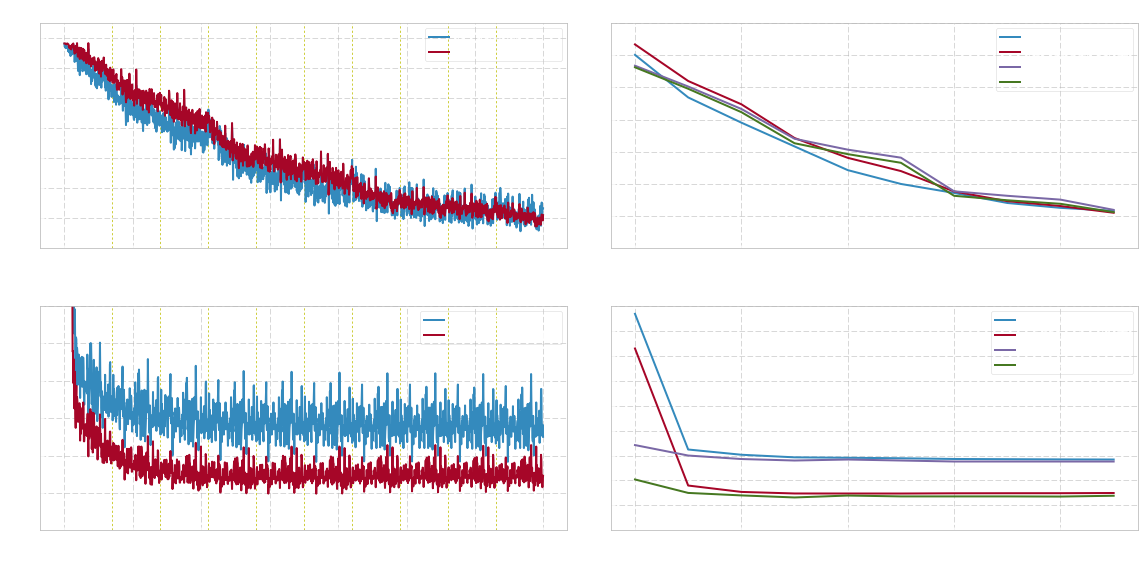

In [26]:
plt.subplot(2,2,1)
plot_batch_ce(
    (net_train_loss['033'],),
    ('net 028 train',),
    (None, (0, 7.5))
)
plt.subplot(2,2,3)
plot_batch_mse(
    (net_train_loss['033'],),
    ('net 028 train',),
    (None, (0, 30))
)
plt.subplot(2,2,2)
plot_epoch_ce(
    (net_mean_train_loss['033'], net_val_loss['033']),
    ('net 033 train', 'net 033 val'),
    (None, (0, 7))
)
plt.subplot(2,2,4)
plot_epoch_mse(
    (net_mean_train_loss['033'], net_val_loss['033']),
    ('net 033 train', 'net 033 val'),
    (None, (0, 45))
)
plt.tight_layout()